**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Production economy and CO2 taxation](#toc1_)    
- 2. [Problem 2: Career choice model](#toc2_)    
- 3. [Problem 3: Barycentric interpolation](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import numpy as np
import scipy
from scipy.stats import norm
from types import SimpleNamespace
import matplotlib.pyplot as plt
from Examproject import *
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

%load_ext autoreload
%autoreload 2

## 1. <a id='toc1_'></a>[Problem 1: Production economy and CO2 taxation](#toc0_)

Consider a production economy with two firms indexed by $j \in \{1,2\}$. Each produce its own good. They solve

$$
\begin{align*}
\max_{y_{j}}\pi_{j}&=p_{j}y_{j}-w_{j}\ell_{j}\\\text{s.t.}\;&y_{j}=A\ell_{j}^{\gamma}.
\end{align*}
$$

Optimal firm behavior is

$$
\begin{align*}
\ell_{j}^{\star}(w,p_{j})&=\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}} \\
y_{j}^{\star}(w,p_{j})&=A\left(\ell_{j}^{\star}(w,p_{j})\right)^{\gamma}
\end{align*}
$$

The implied profits are

$$
\pi_{j}^*(w,p_{j})=\frac{1-\gamma}{\gamma}w\cdot\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}}
$$

A single consumer supplies labor, and consumes the goods the firms produce. She also recieves the implied profits of the firm.<br>
She solves:

$$
\begin{align*}
U(p_1,p_2,w,\tau,T) = \max_{c_{1},c_{2},\ell} & \log(c_{1}^{\alpha}c_{2}^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} \\
\text{s.t.}\,\,\,&p_{1}c_{1}+(p_{2}+\tau)c_{2}=w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})
\end{align*}
$$

where $\tau$ is a tax and $T$ is lump-sum transfer. <br>
For a given $\ell$, it can be shown that optimal behavior is

$$
\begin{align*}
c_{1}(\ell)&=\alpha\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{1}} \\
c_{2}(\ell)&=(1-\alpha)\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{2}+\tau} \\
\end{align*}
$$
Such that optimal behavior is:
$$
\ell^* = \underset{\ell}{\arg\max} \log(\left(c_{1}(\ell)\right)^{\alpha}\cdot \left(c_{2}(\ell)\right)^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} 
$$
With optimal consumption:
$$
\begin{align*}
c_1^*=c_{1}(\ell^*) \\
c_2^*=c_{2}(\ell^*)\\
\end{align*}
$$


The government chooses $\tau$ and balances its budget so $T=\tau c_2^*$. We initially set $\tau,T=0$.

Market clearing requires:

1. Labor market: $\ell^* = \ell_1^* + \ell_2^*$
1. Good market 1: $c_1^* = y_1^*$
1. Good market 2: $c_2^* = y_2^*$


To solve problem 1 we use an instance of the class ProductionEconomy which can be found in Examproject.py.

We start off by initializing the class.

In [2]:
production = ProductionEconomy()

The class ProductionEconomy has been initialized


**Question 1:** Check market clearing conditions for $p_1$ in `linspace(0.1,2.0,10)` and $p_2$ in `linspace(0.1,2.0,10)`. We choose $w=1$ as numeraire.

To calculate the market clearing conditions we use the method check_market_clearing() and iterate over it with all 100 possible price combinations. 

We then visualize the results in three plots (one for each of the market clearing conditions) using the method plot_market_clearing().

Plots showing the results:


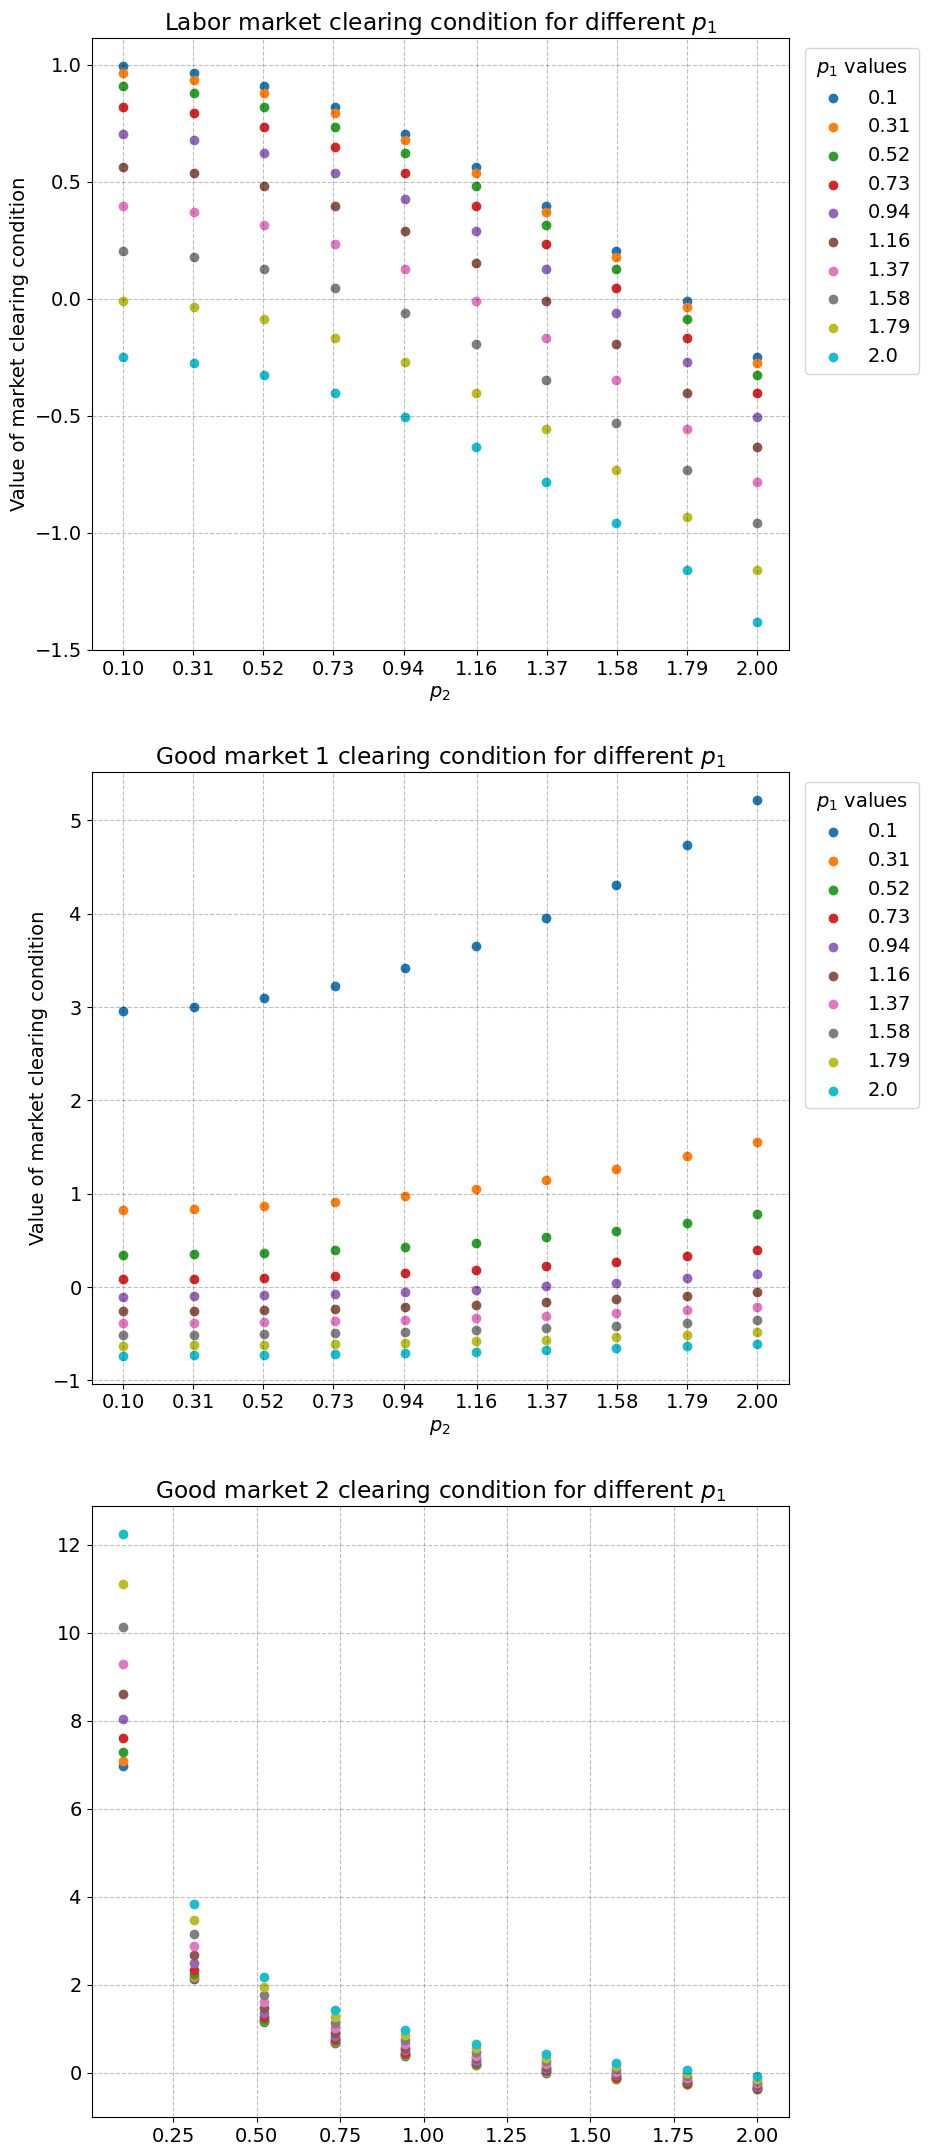

In [3]:
# We define price arrays
p1_array = np.linspace(0.1,2.0,10)
p2_array = np.linspace(0.1,2.0,10)

# We define arrays to hold the values of the market clearing condition
labor_mkt_clearing_array = np.zeros([len(p1_array),len(p2_array)])
good1_mkt_clearing_array = np.zeros([len(p1_array),len(p2_array)])
good2_mkt_clearing_array = np.zeros([len(p1_array),len(p2_array)]) 

# We make a nested loop to loop through all combinations of p1 and p2
for index_p1,i in enumerate(p1_array) :
    for index_p2,j in enumerate(p2_array) :
        p1 = i  ;  p2 = j

        # We calculate the market clearing conditions for a given p1 and p2
        labor_mkt_clearing, good1_mkt_clearing, good2_mkt_clearing = production.check_market_clearing(p1,p2)

        # We assign the market clearing condtions to their corresponding arrays
        labor_mkt_clearing_array[index_p1,index_p2] = labor_mkt_clearing
        good1_mkt_clearing_array[index_p1,index_p2] = good1_mkt_clearing
        good2_mkt_clearing_array[index_p1,index_p2] = good2_mkt_clearing

# We plot the market clearing conditions as a sort of level curve
clearing_conditions = labor_mkt_clearing_array, good1_mkt_clearing_array, good2_mkt_clearing_array 
production.plot_market_clearing(p1_array,p2_array,clearing_conditions)

print(f'Plots showing the results:')

**Question 2:** Find the equilibrium prices $p_1$ and $p_2$.<br>
*Hint: you can use Walras' law to only check 2 of the market clearings*

To find market clearing prices p1 and p2 (with w as numeraire) we use the method compute_equilibrium(). We then print the market clearing prices as well as the market clearing conditions at those prices.

In [4]:
# Initial guess for equilibrium prices
initial_guess = [1,1]

# Compute the market equilibrium prices
p1_eq, p2_eq = production.compute_equilibrium(initial_guess)

# Compute the market clearing conditions with the equilibrium prices 
labor_mkt_clearing, good1_mkt_clearing, good2_mkt_clearing = production.check_market_clearing(p1_eq,p2_eq)

# Print results
print(f'The market clearing prices are p1 = {p1_eq:.3f} and p2 = {p2_eq:.3f}')
print(f'Market clearing condition for good market 1: {good1_mkt_clearing:.3f}')
print(f'Market clearing condition for good market 2: {good2_mkt_clearing:.3f}')
print(f'Market clearing condition for labor market: {labor_mkt_clearing:.3f}')

The market clearing prices are p1 = 0.976 and p2 = 1.491
Market clearing condition for good market 1: 0.000
Market clearing condition for good market 2: 0.000
Market clearing condition for labor market: 0.000


Assume the government care about the social welfare function:

$$
SWF = U - \kappa y_2^*
$$

Here $\kappa$ measures the social cost of carbon emitted by the production of $y_2$ in equilibrium.

**Question 3:** What values of $\tau$ and (implied) $T$ should the government choose to maximize $SWF$?

Note: We didn't manage to succesfully complete this question. However our approach was using the following algorithm. The code is not a part of the class as to make sure it didn't mess with it.

1. Set initial guesses for the tax and transer.
2. The consumer optimizes given the values of the tax and transfer.
3. Market clears.
4. The government sees the choice of the consumer and maximizes the social welfare function taken its budget constraint into account.
5. Repeat 2 through 4 many times, check that convergence has been reached.

The following code is defining functions already defined in the class but allowing for T and tau to vary.

In [5]:
# Needed parameters
par = SimpleNamespace() ; par.A = 1.0 ; par.gamma = 0.5 ; par.alpha = 0.3 ; par.nu = 1.0
par.eps = 2.0 ; par.w = 1.0 ; par.kappa = 0.1

# Function to calculate the consumption of good 1 and 2 given ell
def gov_cons(ell, tau, T, p1, p2) :

    # Compute implied profits
    _, _, pi_1 = production.firm_j(p1)
    _, _, pi_2 = production.firm_j(p2)
    
    # Calculate consumption
    cons_1 = par.alpha * ( par.w * ell + T + pi_1 + pi_2 ) / p1 
    cons_2 = ( 1 - par.alpha ) * ( par.w * ell + T + pi_1 + pi_2 ) / (p2 + tau)
    
    return cons_1, cons_2

# Function to calculate the utility of the consumer
def gov_util(ell, tau, T, p1, p2) :
    
    # Compute consumption
    cons_1, cons_2 = gov_cons(ell, tau, T, p1, p2)

    # Calculate utility
    gov_utility = np.log( ( cons_1 ** par.alpha ) * cons_2 ** ( 1 - par.alpha ) )  - par.nu * ( ell ** ( 1 + par.eps) ) / ( 1 + par.eps )

    return gov_utility

# Function to calculate the optimal consumption
def gov_opt_cons(tau,T,p1,p2) :

    # Define objective function to be minimized
    def objective_cons(ell,tau,T,p1,p2) :
        return -gov_util(ell,tau,T,p1,p2)

    # Minimized wrt. ell
    sol = scipy.optimize.minimize_scalar(objective_cons,
                                         method = 'bounded',
                                         bounds = (0,2),
                                         args=(tau, T, p1, p2) )
    
    # Calculate the optimal values
    ell_gov_opt = sol.x
    c1_gov_opt, c2_gov_opt = gov_cons(sol.x, tau, T, p1, p2)
    return ell_gov_opt, c1_gov_opt, c2_gov_opt

# Check for market clearing
def check_market_clearing(p1,p2,tau,T) :

    # Optimal household behaviour
    ell_gov_opt, c1_gov_opt, c2_gov_opt = gov_opt_cons(tau,T,p1,p2) # Choice of labor supply and optimal consumption

    # Optimal firm behaviour
    ell_1, y_1, _ = production.firm_j(p1)
    ell_2, y_2, _ = production.firm_j(p2)

    # Market clearing
    labor_mkt_clearing = ell_gov_opt - ( ell_1 + ell_2 )
    good1_mkt_clearing = c1_gov_opt - y_1
    good2_mkt_clearing = c2_gov_opt - y_2

    return labor_mkt_clearing, good1_mkt_clearing, good2_mkt_clearing

# Objective function to find the walras equilibrium of the production economy
def objective_walras(p,tau,T) :
    p1,p2 = p
    _, good1_mkt_clearing, good2_mkt_clearing = check_market_clearing(p1,p2,tau,T)
    return good1_mkt_clearing, good2_mkt_clearing


This next segment of code defines the social welfare function as well as the governments budget constraint.

In [6]:
# Now the government has to maximize
def social_welfare(tau, T, ell, p1, p2, y2) :
    U = gov_util(ell, tau, T, p1, p2) # Calculate utility
    emi = par.kappa * y2 # Calculate social cost of carbon
    return U - emi

# The objective function to be minimized
def objective_government(x,ell,p1,p2,y2) :
    SWF = social_welfare(x[0],x[1],ell,p1,p2,y2)
    return -SWF

# The government budget constraint
def budget_constraint(x,c2) :
    return x[1] - x[0] * c2

We then apply the algorithm.

In [8]:
# Initial guesses for the tax and transfer
T = 1 ; tau = 1

# We iterate the algorithm 500 times as is enough for a result to keep repeating itself.
for i in range(500) :

    # Initial guess for market clearing prices
    initial_guess = [1,1]

    # We find the market clearing prices for the given tax and transfer
    res = scipy.optimize.root(
        objective_walras, 
        initial_guess, 
        method='hybr',
        args = (tau,T)
    )

    # We define the equilibrium prices
    p1_eq = res.x[0]
    p2_eq = res.x[1]

    # We then compute the optimal y2, ell and c2 given the tax and transfer
    _, y2_gov_star, _ = production.firm_j(p1_eq)
    ell_gov_star, _, _ = gov_opt_cons(tau, T, p1_eq, p2_eq)
    _, c2_gov_star = gov_cons(ell_gov_star, tau, T, p1_eq, p2_eq)

    # Constraint for the goverments optimization of the SWF
    eq_con = {'type': 'eq', 'fun': budget_constraint, 'args': (c2_gov_star,)}
    
    # We minimize the objective function (Maximize the SWF)
    result = scipy.optimize.minimize(objective_government,
                                     x0 = [tau,T],
                                     method='SLSQP',
                                     bounds = ((0,None),(0,None)),
                                     constraints = [eq_con],
                                     args = (ell_gov_star,p1_eq,p2_eq,y2_gov_star) )

    # We update the optimal taxes before repeating the algorithm
    tau = result.x[0]
    T = result.x[1]

# Print results
print(f'For the government to optimize SWF they should choose tau = {tau:.1f} and T = {T:.1f}')
print(f'The optimal consumption of good 2: c2_star = {c2_gov_star:.1f}')

For the government to optimize SWF they should choose tau = 43519004.3 and T = 2.5
The optimal consumption of good 2: c2_star = 0.0


## 2. <a id='toc2_'></a>[Problem 2: Career choice model](#toc0_)

Consider a graduate $i$ making a choice between entering $J$ different career tracks. <br>
Entering career $j$ yields utility $u^k_{ij}$. This value is unknown to the graduate ex ante, but will ex post be: <br>
$$
    u_{i,j}^k = v_{j} + \epsilon_{i,j}^k
$$

They know that $\epsilon^k_{i,j}\sim \mathcal{N}(0,\sigma^2)$, but they do not observe $\epsilon^k_{i,j}$ before making their career choice. <br>

Consider the concrete case of $J=3$ with:
$$
\begin{align*}
    v_{1} &= 1 \\
    v_{2} &= 2 \\
    v_{3} &= 3
\end{align*}
$$

If the graduates know the values of $v_j$ and the distribution of $\epsilon_{i,j}^k$, they can calculate the expected utility of each career track using simulation: <br>
$$
    \mathbb{E}\left[ u^k_{i,j}\vert v_j \right] \approx v_j + \frac{1}{K}\sum_{k=1}^K \epsilon_{i,j}^k
$$

To solve problem 2 we use an instance of the class Career which can be found in Examproject.py.

We start off by initializing the class.

In [9]:
career = Career()

The class Career has been initialized


**Question 1:** Simulate and calculate expected utility and the average realised utility for $K=10000$ draws, for each career choice $j$.


We define parameters that are used inside the notebook.

In [10]:
par = SimpleNamespace()

par.J = 3 # Career track
par.N = 10 # Graduates
par.F = np.arange(1,par.N + 1) # Array of graduates / friends per graduate per career track

To simulate and calculate the expected utility and the average realized utility we use method expected_career_util(). The results are then printed.

In [11]:
# simulate and calculate the expected utility and the average realized utility
exp_util, avg_real_util = career.expected_career_util()

# Print results
print(f'The expected utility for 1 = {exp_util[0]:.3f}, 2 = {exp_util[1]:.3f} and 3 = {exp_util[2]:.3f}')
print(f'The average realized utility for 1 = {avg_real_util[0]:.3f}, 2 = {avg_real_util[1]:.3f} and 3 = {avg_real_util[2]:.3f}')

The expected utility for 1 = 1.003, 2 = 1.989 and 3 = 3.003
The average realized utility for 1 = 1.003, 2 = 1.989 and 3 = 3.003


Now consider a new scenario: Imagine that the graduate does not know $v_j$. The *only* prior information they have on the value of each job, comes from their $F_{i}$ friends that work in each career $j$. After talking with them, they know the average utility of their friends (which includes their friends' noise term), giving them the prior expecation: <br>
$$
\tilde{u}^k_{i,j}\left( F_{i}\right) = \frac{1}{F_{i}}\sum_{f=1}^{F_{i}} \left(v_{j} + \epsilon^k_{f,j}\right), \; \epsilon^k_{f,j}\sim \mathcal{N}(0,\sigma^2)
$$
For ease of notation consider that each graduate have $F_{i}=i$ friends in each career. <br>

For $K$ times do the following: <br>
1. For each person $i$ draw $J\cdot F_i$ values of $\epsilon_{f,j}^{k}$, and calculate the prior expected utility of each career track, $\tilde{u}^k_{i,j}\left( F_{i}\right)$. <br>
Also draw their own $J$ noise terms, $\epsilon_{i,j}^k$
1. Each person $i$ chooses the career track with the highest expected utility: $$j_i^{k*}= \arg\max_{j\in{1,2\dots,J}}\left\{ \tilde{u}^k_{i,j}\left( F_{i}\right)\right\} $$
1. Store the chosen careers: $j_i^{k*}$, the prior expectation of the value of their chosen career: $\tilde{u}^k_{i,j=j_i^{k*}}\left( F_{i}\right)$, and the realized value of their chosen career track: $u^k_{i,j=j_i^{k*}}=v_{j=j_i^{k*}}+\epsilon_{i,j=j_i^{k*}}^k$.

Chosen values will be: <br>
$i\in\left\{1,2\dots,N\right\}, N=10$ <br>
$F_i = i$<br>
So there are 10 graduates. The first has 1 friend in each career, the second has 2 friends, ... the tenth has 10 friends.

**Question 2:** Simulate and visualize: For each type of graduate, $i$, the share of graduates choosing each career, the average subjective expected utility of the graduates, and the average ex post realized utility given their choice. <br>
That is, calculate and visualize: <br>
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \mathbb{I}\left\{ j=j_i^{k*} \right\}  \;\forall j\in\left\{1,2,\dots,J\right\}
\end{align*}
$$
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \tilde{u}^k_{ij=j_i^{k*}}\left( F_{i}\right)
\end{align*}
$$
And 
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} u^k_{ij=j_i^{k*}} 
\end{align*}
$$
For each graduate $i$.

We simulate the career paths chosen by each graduate using the method simulate_career(). We then compute the share of graduates choosing each career, the average subjective expected utility of the graduates, and the average ex post realized utility given their choice using the method compute_results().

To show our results we make a figure for each. These will be shown together with the visualized results of question 3. The results are therefore after question 3.

In [12]:
# Allocate arrays for the simulation
track_share = np.zeros([par.N,par.J])
avg_prior = np.zeros(par.N)
avg_post = np.zeros(par.N)

# Iterate over the N graduates
for i in par.F :

    # Simulate the career path of graduate i
    simulation = sim_track, sim_prior, sim_post = career.simulate_career(i)

    # Compute results
    track_share_i, avg_prior_i, avg_post_i = career.compute_results(simulation)
    
    # Add the computed results to their corresponding array
    track_share[i-1] = track_share_i
    avg_prior[i-1] = avg_prior_i
    avg_post[i-1] = avg_post_i

# Save the results to be used for visualizing.
simulated_results_q2 = track_share, avg_prior, avg_post


After a year of working in their career, the graduates learn $u^k_{ij}$ for their chosen job $j_i^{k*}$ perfectly. <br>
The can switch to one of the two remaining careers, for which they have the same prior as before, but it will now include a switching cost of $c$ which is known.
Their new priors can be written as: 
$$
\tilde{u}^{k,2}_{ij}\left( F_{i}\right) = \begin{cases}
            \tilde{u}^k_{ij}\left( F_{i}\right)-c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

We will set $c=1$.

Their realized utility will be: <br>
$$
u^{k,2}_{ij}= \begin{cases}
            u_{ij}^k -c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

**Question 3:** Following the same approach as in question 2, find the new optimal career choice for each $i$, $k$. Then for each $i$, calculate the average subjective expected utility from their new optimal career choice, and the ex post realized utility of that career. Also, for each $i$, calculate the share of graduates that chooses to switch careers, conditional on which career they chose in the first year. <br>

We simulate the career path chosen and subsequent possible career change of the gradutes using the method simulate_career() with the option allow_change set to True. We then compute the average subjective expected utility from their new optimal career choice, the ex post realized utility of that career and the share of graduates that chooses to switch career given their initial career. The results are computed using the method compute_results() with the option allow_change set to True.

We then visualize the results in three figures together with the results from question 2, such that they can be easily compared.

Results from question 2 (left) and question 3 (right):


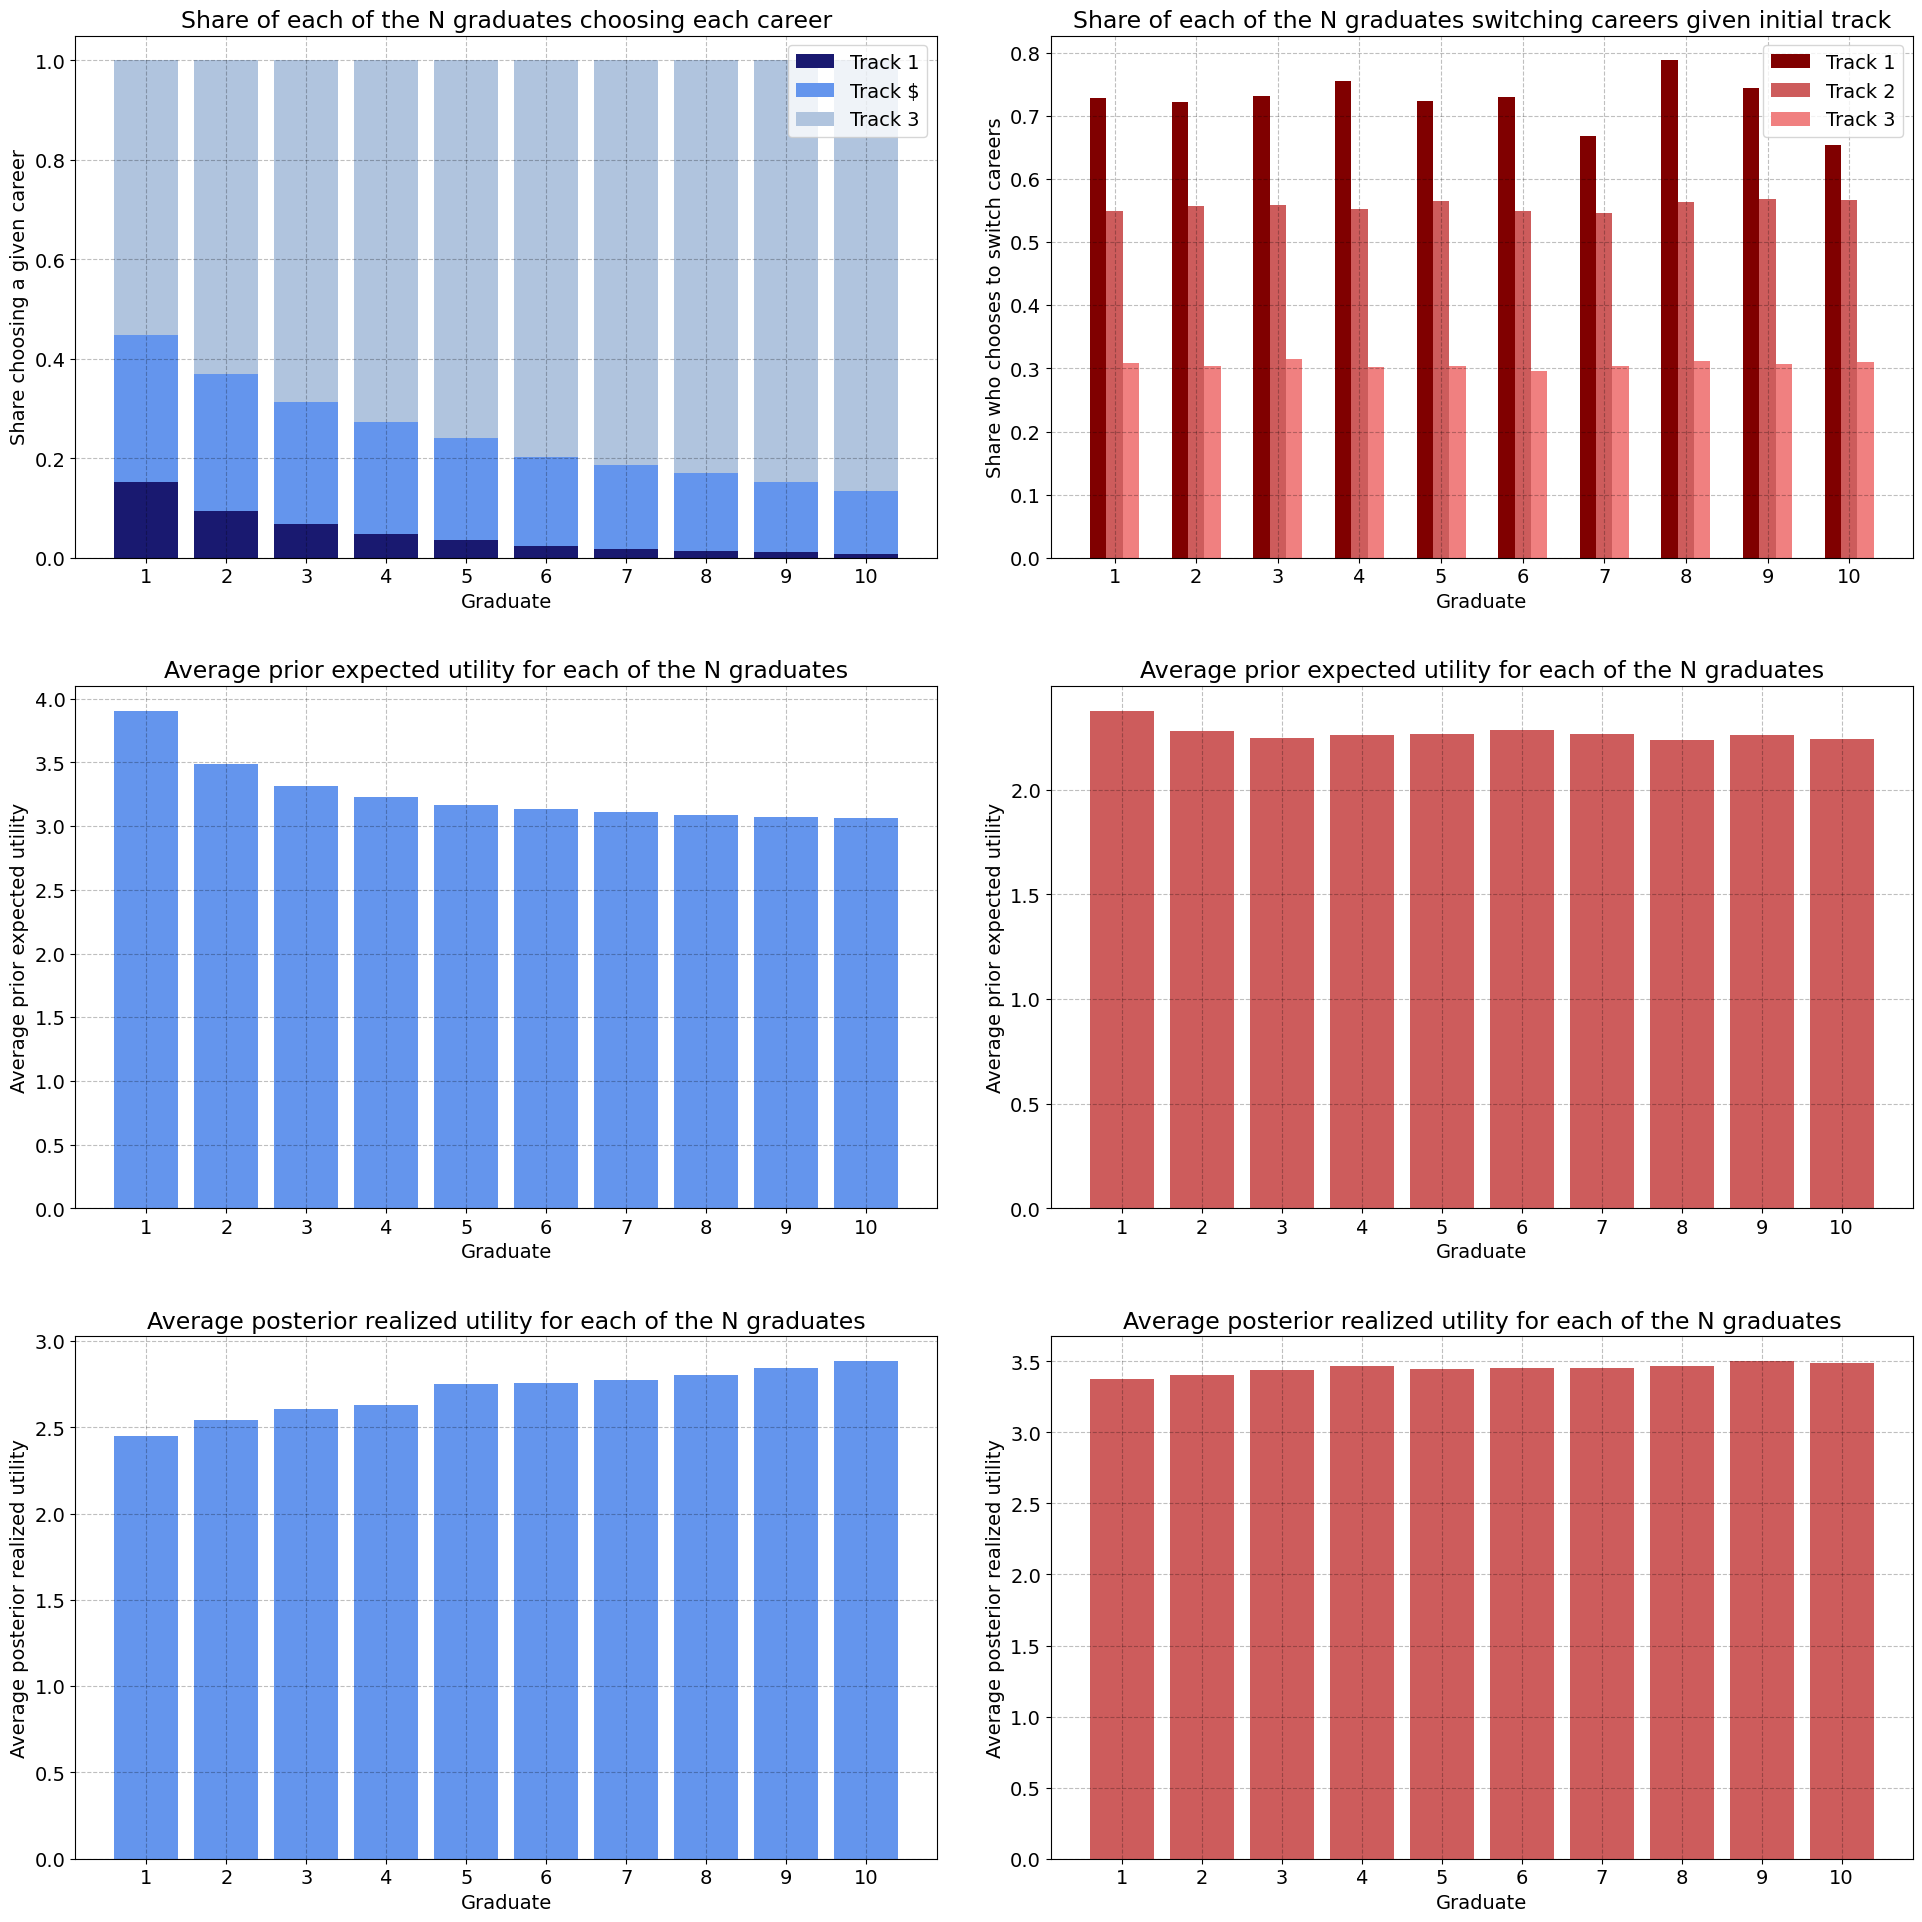

In [13]:
change_share = np.zeros([par.N,par.J])
new_avg_prior = np.zeros(par.N)
new_avg_post = np.zeros(par.N)

for i in par.F :

    # Simulate the career path of graduate i
    simulation = sim_prev_track, sim_track, sim_prior, sim_post, change_each_track = career.simulate_career(i, allow_change = True)

    # Compute results
    change_share_i, avg_prior_i, avg_post_i = career.compute_results(simulation, allow_change = True)
    
    change_share[i-1] = change_share_i
    new_avg_prior[i-1] = avg_prior_i
    new_avg_post[i-1] = avg_post_i

simulated_results_q3 = change_share, new_avg_prior, new_avg_post

career.plot_results(simulated_results_q2,simulated_results_q3)

print('Results from question 2 (left) and question 3 (right):')

## 3. <a id='toc3_'></a>[Problem 3: Barycentric interpolation](#toc0_)

**Problem:** We have a set of random points in the unit square,

$$
\mathcal{X} = \{(x_1,x_2)\,|\,x_1\sim\mathcal{U}(0,1),x_2\sim\mathcal{U}(0,1)\}.
$$

For these points, we know the value of some function $f(x_1,x_2)$,

$$
\mathcal{F} = \{f(x_1,x_2) \,|\, (x_1,x_2) \in \mathcal{X}\}.
$$

Now we want to approximate the value $f(y_1,y_2)$ for some  $y=(y_1,y_2)$, where $y_1\sim\mathcal{U}(0,1)$ and $y_2\sim\mathcal{U}(0,1)$.

**Building block I**

For an arbitrary triangle $ABC$ and a point $y$, define the so-called barycentric coordinates as:

$$
\begin{align*}
  r^{ABC}_1 &= \frac{(B_2-C_2)(y_1-C_1) + (C_1-B_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_2 &= \frac{(C_2-A_2)(y_1-C_1) + (A_1-C_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_3 &= 1 - r_1 - r_2.
\end{align*}
$$

If $r^{ABC}_1 \in [0,1]$, $r^{ABC}_2 \in [0,1]$, and $r^{ABC}_3 \in [0,1]$, then the point is inside the triangle.

We always have $y = r^{ABC}_1 A + r^{ABC}_2 B + r^{ABC}_3 C$.

**Building block II**

Define the following points:

$$
\begin{align*}
A&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}>y_{2}\\
B&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}<y_{2}\\
C&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}<y_{2}\\
D&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}>y_{2}.
\end{align*}
$$

**Algorithm:**

1. Compute $A$, $B$, $C$, and $D$. If not possible return `NaN`.
1. If $y$ is inside the triangle $ABC$ return $r^{ABC}_1 f(A) + r^{ABC}_2 f(B) + r^{ABC}_3 f(C)$.
1. If $y$ is inside the triangle $CDA$ return $r^{CDA}_1 f(C) + r^{CDA}_2 f(D) + r^{CDA}_3 f(A)$.
1. Return `NaN`.



**Sample:**

In [14]:
rng = np.random.default_rng(2024)

X = rng.uniform(size=(50,2))
y = rng.uniform(size=(2,))

To solve problem 3 we use an instance of the class BarycentricInterpolation which can be found in Examproject.py.

We start off by initializing the class.

In [15]:
bary = BarycentricInterpolation()

The class BarycentricInterpolation has been initialized


**Questions 1:** Find $A$, $B$, $C$ and $D$. Illustrate these together with $X$, $y$ and the triangles $ABC$ and $CDA$.

We find the points A, B, C and D using the method compute_points. We then plot the points together with X,y and the two triangles using the method plot_bary().

Point A = (0.261,0.436)
Point B = (0.213,0.274)
Point C = (0.101,0.280)
Point D = (0.206,0.443)


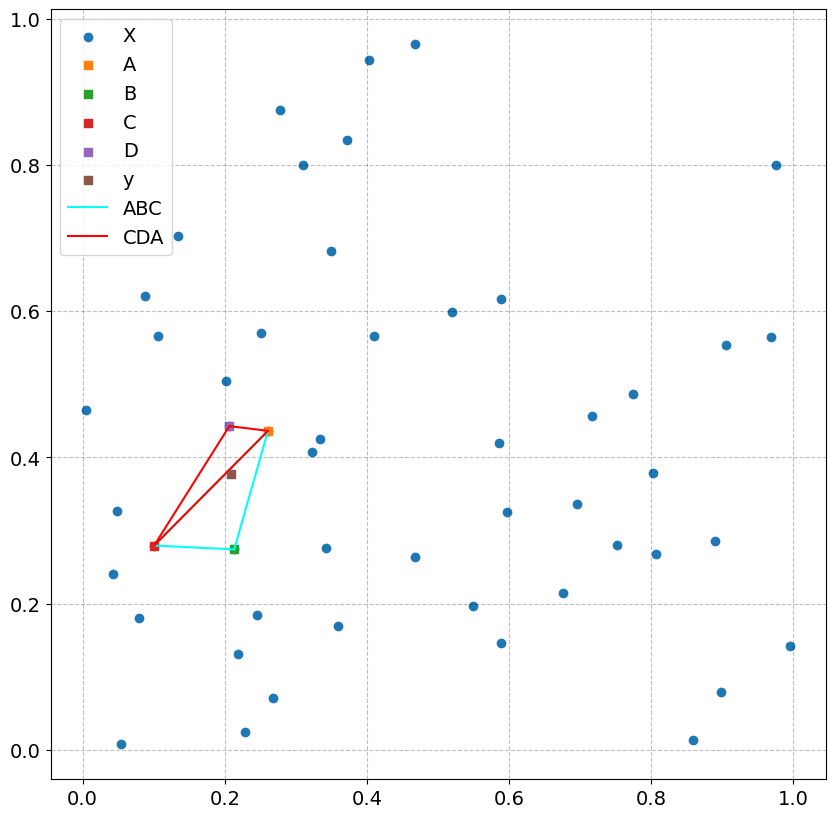

In [16]:
# Compute the points A, B, C and D
A,B,C,D = bary.compute_points(X,y)

# Print A, B, C and D
print(f'Point A = ({A[0]:.3f},{A[1]:.3f})')
print(f'Point B = ({B[0]:.3f},{B[1]:.3f})')
print(f'Point C = ({C[0]:.3f},{C[1]:.3f})')
print(f'Point D = ({D[0]:.3f},{D[1]:.3f})')

# Plot the results togehter with X and y
bary.plot_bary(A,B,C,D,X,y)

**Question 2:** Compute the barycentric coordinates of the point $y$ with respect to the triangles $ABC$ and $CDA$. Which triangle is $y$ located inside?

We compute the barycentric coordinates for both triangles using the method compute_bary_coordinates(). We also check if the stated relation between y and the barycentric coordinates are true. The results are then printed.

In [17]:
# Calculate barycentric coordinates
r1_ABC, r2_ABC, r3_ABC = bary.compute_bary_coordinates(A,B,C,y)
r1_CDA, r2_CDA, r3_CDA = bary.compute_bary_coordinates(C,D,A,y)

# Check the relation
y_ABC = r1_ABC * A + r2_ABC * B + r3_ABC * C
y_CDA = r1_CDA * C + r2_CDA * D + r3_CDA * A

# Print results
print(f'Barycentric coordinates for triangle ABC: ({r1_ABC:.3f},{r2_ABC:.3f},{r3_ABC:.3f})')
print(f'Barycentric coordinates for triangle CDA: ({r1_CDA:.3f},{r2_CDA:.3f},{r3_CDA:.3f})')
print(f'The point y is therefore located inside the triangle ABC') 
print()
print(f'We also check the stated identity for both triangle ABC and CDA')
print(f'The point y is ({y[0]:.3f},{y[1]:.3f}). We compute y for triangle ABC as ({y_ABC[0]:.3f},{y_ABC[1]:.3f}) and y for triangle CDA as ({y_CDA[0]:.3f},{y_CDA[1]:.3f}).')

Barycentric coordinates for triangle ABC: (0.629,0.069,0.302)
Barycentric coordinates for triangle CDA: (0.368,-0.134,0.766)
The point y is therefore located inside the triangle ABC

We also check the stated identity for both triangle ABC and CDA
The point y is (0.209,0.378). We compute y for triangle ABC as (0.209,0.378) and y for triangle CDA as (0.209,0.378).


Now consider the function:
$$
f(x_1,x_2) = x_1 \cdot x_2
$$

In [18]:
f = lambda x: x[0]*x[1]
F = np.array([f(x) for x in X])

**Question 3:** Compute the approximation of $f(y)$ using the full algorithm. Compare with the true value.

We employ the full algorithm using the method algorithm(). We also compute the true function value. The results are printed.

In [19]:
true_val = f(y) ; 
f_approx = bary.algorithm(X,y,f)

print(f'The true value of f(y) is {true_val:.3f}')
print(f'The approximation of the value f(y) is {f_approx:.3f}')

The true value of f(y) is 0.079
The approximation of the value f(y) is 0.084


**Question 4:** Repeat question 3 for all points in the set $Y$.

To repeat we loop over Y and feed the points into the algorithm. We also compute the true function value. The results for the 5 points are printed.

In [20]:
Y = np.array([(0.2,0.2),(0.8,0.2),(0.8,0.8),(0.8,0.2),(0.5,0.5)])

# Loop over each point in Y
for y in Y :

    # We approximate f using the algorithm
    f_approx = bary.algorithm(X,y,f)

    # We compute the true value of the function
    true_val = f(y)

    # Print results
    print(f'For (y1,y2) = ({y[0]},{y[1]}) --> f({y[0]},{y[1]}) = {true_val:.3f} --> approximated function value is {f_approx:.3f}')


For (y1,y2) = (0.2,0.2) --> f(0.2,0.2) = 0.040 --> approximated function value is 0.040
For (y1,y2) = (0.8,0.2) --> f(0.8,0.2) = 0.160 --> approximated function value is 0.159
For (y1,y2) = (0.8,0.8) --> f(0.8,0.8) = 0.640 --> approximated function value is nan
For (y1,y2) = (0.8,0.2) --> f(0.8,0.2) = 0.160 --> approximated function value is 0.159
For (y1,y2) = (0.5,0.5) --> f(0.5,0.5) = 0.250 --> approximated function value is 0.251
